In [1]:
# imports
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import yaml

from utils.data_utils import CustomTransform

In [2]:
with open('../checkpoints/clip/cloome_scale_0.3/config.yaml') as f:
    config_file = yaml.safe_load(f)

# just for this config, add a parameter batch_size
config_file['batch_size'] = 256

chkpt = torch.load('../checkpoints/clip/cloome_scale_0.3/best_val.pt')

In [3]:
# load model
from models.clip.model import CLIP, projection, ImageEncoder
from models.clip.trainer import CLIPTrainer
from utils.data_loader import CLIPDataLoader
from utils.data_utils import CustomTransform

In [9]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
transform = CustomTransform()

image_encoder = ImageEncoder().to(device)

# image projection head
image_projection = projection(
input_dim=config_file['image_proj_input_size'],
hidden_sizes=config_file['image_proj_hidden_sizes'],
output_dim=config_file['image_proj_output_size']
).to(device)
print("image projection head with hidden sizes: ", config_file['image_proj_hidden_sizes'], "loaded!")
# smiles projection network
mol_projection = projection(
input_dim=config_file['mol_proj_input_size'],
hidden_sizes=config_file['mol_proj_hidden_sizes'],
output_dim=config_file['mol_proj_output_size']
).to(device)
print("mol projection head with hidden sizes: ", config_file['mol_proj_hidden_sizes'], "loaded!")

# final clip model
model = CLIP(
image_encoder=image_encoder,
init_inv_tau=config_file['inv_tau'],
learnable_inv_tau=config_file['learnable_inv_tau'],
image_projection_network=image_projection,
mol_projection_network=mol_projection
).to(device)

image projection head with hidden sizes:  [256, 128] loaded!
mol projection head with hidden sizes:  [512, 256, 128] loaded!


In [10]:
chkpt.keys()

dict_keys(['epoch', 'state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss'])

In [11]:
# load model weights
model.load_state_dict(chkpt['state_dict'])

<All keys matched successfully>

In [12]:
# load data
data_loader = CLIPDataLoader(device, transform, **config_file)
train_loader, val_loader = data_loader.train_dataloader(), data_loader.test_dataloader()
len(val_loader.dataset)

9788

In [13]:
val_images, val_smiles_embeds, val_smiles = [], [], []

for i, batch in enumerate(val_loader):
    val_images.append(batch['image'])
    val_smiles_embeds.append(batch['smiles_emb'])
    val_smiles.append(batch['smiles'])

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 3 has a total capacty of 15.77 GiB of which 37.31 MiB is free. Process 1319209 has 14.67 GiB memory in use. Process 1323724 has 1.05 GiB memory in use. Of the allocated memory 749.11 MiB is allocated by PyTorch, and 20.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [30]:
val_images = torch.cat(val_images, dim=0)
val_smiles_embeds = torch.cat(val_smiles_embeds, dim=0)

In [31]:
val_images.size(), val_smiles_embeds.size()

(torch.Size([9788, 3, 96, 96]), torch.Size([9788, 2048]))

In [39]:
batch_size = val_images.size(0)

random_indices = torch.randperm(batch_size)[:200]

with torch.no_grad():

    i_embeds, m_embeds, _ = model(val_images[random_indices].to(device), 
                                  val_smiles_embeds[random_indices].to(device))

In [40]:
i_embeds.size(), m_embeds.size()

(torch.Size([200, 64]), torch.Size([200, 64]))

In [53]:
i_embeds[1]

tensor([-1.9989e-02,  2.4339e-01,  2.2989e-02,  1.0967e-01,  4.3089e-02,
         1.1216e-01, -6.7398e-03, -2.9812e-03,  1.4558e-03, -2.9499e-02,
        -6.3039e-03,  1.4148e-01, -1.4461e-01,  1.2134e-01,  4.1625e-01,
         3.1307e-02,  2.4642e-02,  1.8286e-01, -5.0529e-02,  6.1564e-02,
        -5.8703e-03,  6.9961e-03,  6.4134e-03,  1.0516e-04,  3.5855e-02,
         1.5951e-01, -4.3460e-03, -1.4920e-02, -3.7518e-01, -1.0173e-02,
         1.5681e-01, -7.1501e-02,  1.1653e-01, -7.6059e-03, -1.4316e-03,
         5.1739e-02, -1.4791e-01, -1.5374e-02, -2.9113e-02,  2.0912e-02,
        -1.9912e-02,  2.4434e-01,  2.3064e-01,  2.7761e-02,  1.4324e-02,
        -2.7323e-03, -3.8618e-03, -8.5160e-02, -5.9297e-02,  5.1241e-02,
         1.5931e-02, -8.6636e-03, -1.9341e-02, -2.5364e-02,  8.8517e-03,
        -6.1539e-02,  2.1009e-01, -5.7483e-02, -6.4516e-03, -1.1968e-02,
         3.5693e-02, -3.7729e-01, -5.9412e-03, -4.9799e-03], device='cuda:0')

In [54]:
m_embeds[1]

tensor([ 0.0560,  0.1959, -0.1010,  0.0393,  0.0944, -0.1094, -0.0115, -0.0217,
        -0.0207, -0.0058,  0.0970, -0.1943, -0.1307,  0.0203, -0.0124,  0.0828,
        -0.3256,  0.0300, -0.1210, -0.1667, -0.0845,  0.0032,  0.0038,  0.0085,
         0.0038, -0.0324,  0.0448,  0.1049, -0.0330,  0.0066, -0.0231,  0.0340,
        -0.2963,  0.0490, -0.2485, -0.0139,  0.0103,  0.0228,  0.1626,  0.0209,
         0.0075,  0.1555,  0.1154,  0.0432,  0.1025,  0.3972,  0.0104,  0.0121,
         0.0682, -0.0083,  0.0159, -0.0525,  0.0724, -0.0047, -0.0757,  0.0328,
         0.0369, -0.0013, -0.0013,  0.0401,  0.0261,  0.0042, -0.0050, -0.0372],
       device='cuda:0')

In [41]:
# get CLIP similarity matrx for validation set
i_embeds_norm = i_embeds / i_embeds.norm(dim=-1, keepdim=True)
m_embeds_norm = m_embeds / m_embeds.norm(dim=-1, keepdim=True)

def get_similarity_matrix(i_embeds, m_embeds):
    return i_embeds @ m_embeds.T

In [42]:
sim_mat = get_similarity_matrix(i_embeds_norm, m_embeds_norm)

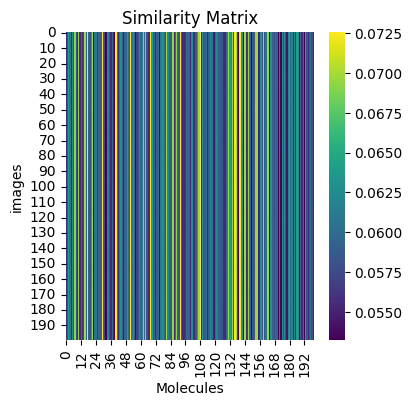

In [49]:
plt.figure(figsize=(4, 4))
sns.heatmap(sim_mat.cpu().numpy(), annot=False, fmt=".2f", cmap="viridis")

# Add labels and title
plt.xlabel('Molecules')
plt.ylabel('images')
plt.title('Similarity Matrix')

# Show the plot
plt.show()

In [59]:
val_images.size()

torch.Size([9788, 3, 96, 96])

In [58]:
# plot some images
def plot_images(images, labels, n_images=5):
    fig, axes = plt.subplots(1, n_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        ax.axis('off')
        ax.set_title(labels[i])
    plt.show()

rand_indices = torch.randperm(val_images.size(0))[:5]
rand_indices_list = rand_indices.tolist()  # Convert tensor indices to a list of integers
plot_images(val_images[rand_indices], [val_smiles[i] for i in rand_indices_list])

IndexError: list index out of range